# Introduction: Bayesian Optimization using Hyperopt

In this notebook we will walk through the basics of [Bayesian Model-Based Optimization](https://sigopt.com/static/pdf/SigOpt_Bayesian_Optimization_Primer.pdf) using [Hyperopt](https://jaberg.github.io/hyperopt/) to find the minimum of a function. After we are familiar with the basic concepts, we can use these powerful methods to solve many problems, inlcuding [hyperparamter optimization](https://en.wikipedia.org/wiki/Hyperparameter_optimization) of machine learning models. 

## Bayesian Model-Based Optimization Primer

There are four parts to an optimization problem:

1. Objective function: what we want to minimize
2. Domain space: values of the parameters over which to minimize the objective
3. Hyperparameter optimization function: constructs the surrogate function and chooses next values to evaluate
4. Trials: score, parameter pairs recorded each time we evaluate the objective function

Evaluating the objective function is the expensive part of optimization, so ideally we want to limit calls to this function. One way we can limit calls is by choosing the next values to try in the objective function based on the past results. 
Bayesian optimization differs from random or grid search by doing exactly this: rather than just selecting from a grid __uninformed__ by past objective function evaluations, Bayesian methods take into account the previous results to try more promising values. They work by constructing a probability model of the objective function (called a surrogate function) $p(\text{score} | \text{parameters}$ which is much easier to optimize than the actual objective function. 

After each evaluation of the objective function, the algorithm updates the probability model (usually given as $p(y | x)$ incorporating the new results. [Sequential Model-Based Optimization (SMBO) methods are a formalization of Bayesian optimization](https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f) that update the probability model sequentially: every evaluation of the objective function with a set of values updates the model with the idea that eventually the model will come to represent the true objective function. This is an application of Bayesian Reasoning. The algorithm forms an initial idea of the objective function and updates it with each new piece of evidence.

The next values to try in the objective function are selected by the algorithm optmizing the probability model (surrogate function) usually with a criteria known as Expected Improvement. Finding the values that will yield the greatest expected improvement in the surrogate function is much cheaper than evaluating the objective function itself. By choosing the next values based on a model rather than randomly, the hope is that the algorithm with converge to the true best values much quicker. The overall goal is to evaluate the objective function fewer times by spending a little more time choosing the next values. Overall, Bayesian Optimization and SMBO methods:

* Converge to a lower score of the objective function than random search
* Require far less time to find the optimum of the objective function

So, we get both faster optimization and a better result. These are both two desirable outcomes especially when we are working with hyperparameter tuning of machine learning models! 

### Sequential Model Based Optimization using the Tree Parzen Estimator

SMBO methods differ in part 3, the algorithm used to construct the probability model (also called the Surrogate Function). Several options are for the surrogate function are:

* Gaussian Processes
* Tree-structured Parzen Estimator
* Random Forest Regression

Hyperopt implements the Tree-strucuted Parzen Estimator. The details of this algorithm are not that complicated, but we will not discuss them in this notebook (for details refer to [this article.]) We don't need to worry about implementing the algorithm because Hyperopt takes care of that for us. We just have to make sure we have properly defined the __objective function__ and the __domain of values to search over__. Then, we select the algorithm and let it run. Hyperopt will automatically keep track of past results to inform the model (part 4.) but we can also use a custom object to get more information about the optimization procedure. 

## Hyperopt

Hyperopt is an open-source Python library for Bayesian optimization that implements SMBO using the Tree-structured Parzen Estimator. There are a number of libraries available for Bayesian optimization and Hyperopt differs in that it is the only one to currently offer the Tree Parzen Estimator. Other libraries use a Gaussian Process or a Random Forest regression for the surrogate function (probability model). 

In this notebook, we will implement both random search (Hyperopt has a method for this) as well as the Tree Parzen Estimator, a Sequential Model-Based Optimization method. We will use a simple problem that will allow us to learn the basics as well as a number of techniques that will be very helpful when we get to more complex use cases. With all that out of the way, let's get started with Hyperopt! 

#### Resources

For more details on Bayesian Model Based Optimization, here are some good articles:

* Algorithms for Hyper-Parameter Optimization [Link](https://papers.nips.cc/paper/4443-algorithms-for-hyper-parameter-optimization.pdf)
* Making a Science of Model Search: Hyperparameter Optimization in Hundreds of Dimensions for Vision Architectures [Link](http://proceedings.mlr.press/v28/bergstra13.pdf)
* Bayesian Optimization Primer [Link](https://sigopt.com/static/pdf/SigOpt_Bayesian_Optimization_Primer.pdf)
* Taking the Human Out of the Loop: A Review of Bayesian Optimization [Link](https://www.cs.ox.ac.uk/people/nando.defreitas/publications/BayesOptLoop.pdf)

In [1]:
# Good old pandas and numpy
import pandas as pd
import numpy as np

# Unfortunately I'm still using matplotlib for graphs
import matplotlib.pyplot as plt
import seaborn as sns

# Objective


For our objective function, we will use a simple polynomial function with the goal being to find the minimu value. This function has one global minimum over the range we define it as well as one local minimum.

When we define the objective function, we must make sure it returns a single real-value number to _minimize_. If we use a metric such as accuracy, then we would have to return the _negative_ of accuracy to tell our model to find a better accuracy! We can also return a dictionary (we will see this later) where one of the keys must be "loss". Here we will just return the output of the function $f(x)$

In [2]:
def objective(x):
    """Objective function to minimize"""
    
    # Create the polynomial object
    f = np.poly1d([1, -2, -28, 28, 12, -26, 100])

    # Return the value of the polynomial
    return f(x) * 0.05

Minimum of -219.8012 occurs at 4.8779


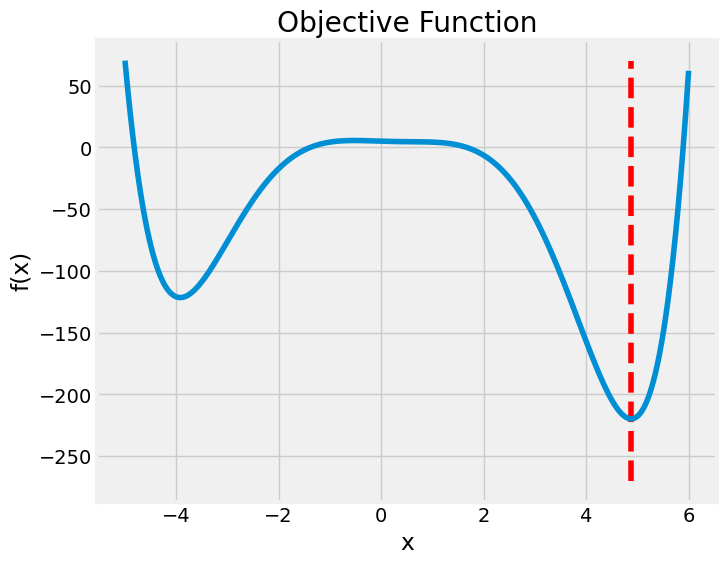

In [3]:
# Space over which to evluate the function is -5 to 6
x = np.linspace(-5, 6, 10000)
y = objective(x)

miny = min(y)
minx = x[np.argmin(y)]

# Visualize the function
plt.figure(figsize = (8, 6))
plt.style.use('fivethirtyeight')
plt.title('Objective Function'); plt.xlabel('x'); plt.ylabel('f(x)')
plt.vlines(minx, min(y)- 50, max(y), linestyles = '--', colors = 'r')
plt.plot(x, y);

# Print out the minimum of the function and value
print('Minimum of %0.4f occurs at %0.4f' % (miny, minx))

# Domain

The domain is the values of x over which we evaluate the function. First we can use a uniform distribution over the space our function is defined.

In [4]:
from hyperopt import hp

# Create the domain space
space = hp.uniform('x', -5, 6)

We can draw samples from the space using a Hyperopt utility. This is useful for visualizing a distribution.

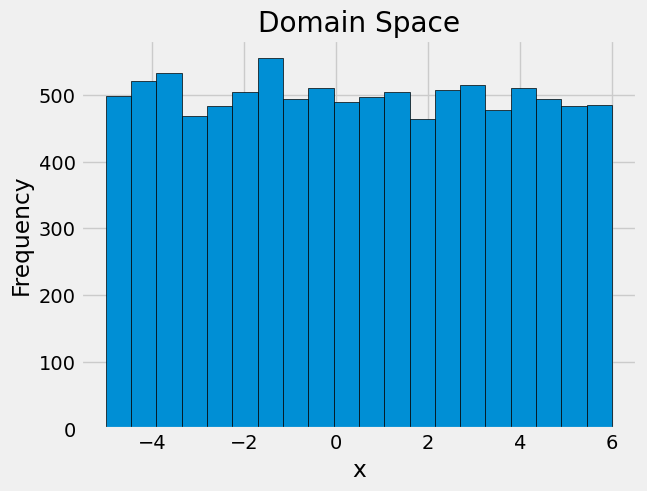

In [5]:
from hyperopt.pyll.stochastic import sample


samples = []

# Sample 10000 values from the range
for _ in range(10000):
    samples.append(sample(space))
    

# Histogram of the values
plt.hist(samples, bins = 20, edgecolor = 'black'); 
plt.xlabel('x'); plt.ylabel('Frequency'); plt.title('Domain Space');

When running, our algorithm will sample values from this distribution, initially at random as it explores the domain space, but then over time, it will "focus" on the most promising values. Therefore, the algorithm should more values around 4.9, the minimum of the function. We can compare this to random search which should try values evenly from the entire distribution.

# Hyperparameter Optimization Algorithm

There are two choices for a hyperparameter optimization algorithm in Hyperopt: random and Tree Parzen Estimator. We can use both and compare the results. Using the `suggest` algorithm in these families automatically configures the algorithm for us. 

In [6]:
from hyperopt import rand, tpe

# Create the algorithms
tpe_algo = tpe.suggest
rand_algo = rand.suggest

# History

Storing the history is as simple as making a `Trials` object that we pass into the function call. This is not strictly necessary, but it gives us information that we can use to understand what the algorithm is doing.

In [7]:
from hyperopt import Trials

# Create two trials objects
tpe_trials = Trials()
rand_trials = Trials()

# Run the Optimization

Now that all four parts are in place, we are ready to minimize! Let's do 2000 runs of the minimization with both the random algorithm and the Tree Parzen Estimator algorithm. 

The `fmin` function takes in exactly the four parts specified above as well as the maximum number of evaluations to run. We will also set a `rstate` for reproducible results across multiple runs.

In [11]:
from hyperopt import fmin

# Run 2000 evals with the tpe algorithm
tpe_best = fmin(fn=objective, space=space, algo=tpe_algo, trials=tpe_trials, 
                max_evals=2000, rstate= np.random.default_rng(42))

print(tpe_best)

# Run 2000 evals with the random algorithm
rand_best = fmin(fn=objective, space=space, algo=rand_algo, trials=rand_trials, 
                 max_evals=2000, rstate= np.random.default_rng(42))

100%|████| 2000/2000 [00:07<00:00, 256.12trial/s, best loss: -219.8011807501099]
{'x': 4.8777086787963935}
100%|████| 2000/2000 [00:02<00:00, 819.29trial/s, best loss: -219.7984203398709]


In [12]:
# Print out information about losses
print('Minimum loss attained with TPE:    {:.4f}'.format(tpe_trials.best_trial['result']['loss']))
print('Minimum loss attained with random: {:.4f}'.format(rand_trials.best_trial['result']['loss']))
print('Actual minimum of f(x):            {:.4f}'.format(miny))

# Print out information about number of trials
print('\nNumber of trials needed to attain minimum with TPE:    {}'.format(tpe_trials.best_trial['misc']['idxs']['x'][0]))
print('Number of trials needed to attain minimum with random: {}'.format(rand_trials.best_trial['misc']['idxs']['x'][0]))

# Print out information about value of x
print('\nBest value of x from TPE:    {:.4f}'.format(tpe_best['x']))
print('Best value of x from random: {:.4f}'.format(rand_best['x']))
print('Actual best value of x:      {:.4f}'.format(minx))

Minimum loss attained with TPE:    -219.8012
Minimum loss attained with random: -219.7984
Actual minimum of f(x):            -219.8012

Number of trials needed to attain minimum with TPE:    1154
Number of trials needed to attain minimum with random: 1735

Best value of x from TPE:    4.8777
Best value of x from random: 4.8828
Actual best value of x:      4.8779


The Tree Parzen estimator and random search found the exact same minimum of the function to 4 decimal places. Sometimes even random search gets lucky (especially when we run it for so many iterations. However, we can see that TPE found the minimum in about half the number of iterations. After finding this minimum, we could have stopped running the algorith!

Let's see if there is any difference in time between the two methods. We can use the built in Jupyter magic command for timing (running the function 3 times).

In [13]:
%%timeit -n 3
# Run 2000 evals with the tpe algorithm
best = fmin(fn=objective, space=space, algo=tpe_algo, max_evals=200)

100%|█████| 200/200 [00:00<00:00, 867.71trial/s, best loss: -219.79606593465675]
254 ms ± 12.3 ms per loop (mean ± std. dev. of 7 runs, 3 loops each)


In [14]:
%%timeit -n 3

# Run 2000 evals with the random algorithm
best = fmin(fn=objective, space=space, algo=rand_algo, max_evals=200)

100%|████| 200/200 [00:00<00:00, 3731.70trial/s, best loss: -219.43922074783538]
52.7 ms ± 1.21 ms per loop (mean ± std. dev. of 7 runs, 3 loops each)


As a point of interest, the random algorithm ran about 5 times faster than the tpe algorithm. This shows that the TPE method is taking more time to propose the next set of parameters while the random method is just choosing from the space well, randomly. The extra time to choose the next parmaeters is made up for by choosing better parameters that should let us make fewer overall calls to the objective function (which is the most expensive part of optimization). Here we ran the same number of totals calls, but this was probably not necessary because the Tree Parzen Estimator will converge on the optimum quickly without the need for more iterations.

# Results

We see that both models returned values very close to the optimal. To see how they differ in the search procedure, we can take a look at the trials objects. 

In [15]:
tpe_results = pd.DataFrame({'loss': [x['loss'] for x in tpe_trials.results], 'iteration': tpe_trials.idxs_vals[0]['x'],
                            'x': tpe_trials.idxs_vals[1]['x']})
                            
tpe_results.head()

,loss,iteration,x
0,-151.573739,2,3.950209
1,-6.871627,3,-1.695365
2,-102.075271,4,-3.383409
3,5.540063,5,-0.558446
4,4.573759,6,0.531941


Extracting these results was a little work. We could have formatted the objective function to return more useful information (in a little bit we'll how to do this).

First we can plot the values that were evaluated over time. As the algorithm progresses, these should tend to cluster around the actual best value (near 4.9)

In [16]:
tpe_results['rolling_average_x'] = tpe_results['x'].rolling(50).mean().fillna(method = 'bfill')
tpe_results['rolling_average_loss'] = tpe_results['loss'].rolling(50).mean().fillna(method = 'bfill')
tpe_results.head()

,loss,iteration,x,rolling_average_x,rolling_average_loss
0,-151.573739,2,3.950209,1.8086,-78.674938
1,-6.871627,3,-1.695365,1.8086,-78.674938
2,-102.075271,4,-3.383409,1.8086,-78.674938
3,5.540063,5,-0.558446,1.8086,-78.674938
4,4.573759,6,0.531941,1.8086,-78.674938


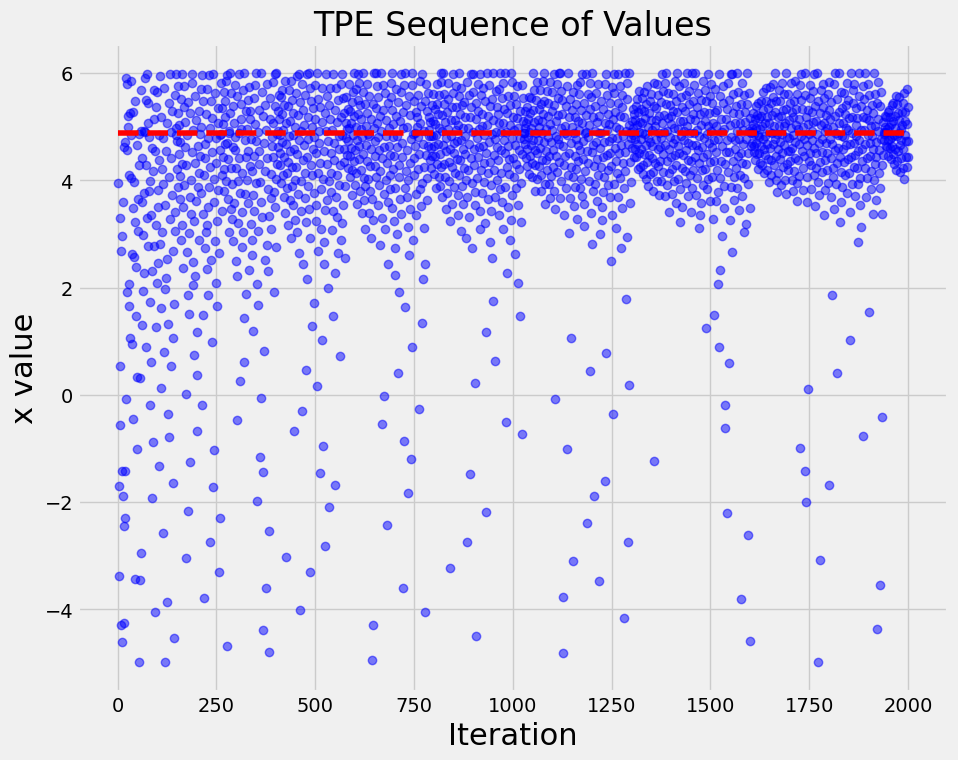

In [17]:
plt.figure(figsize = (10, 8))
plt.plot(tpe_results['iteration'], tpe_results['x'],  'bo', alpha = 0.5);
plt.xlabel('Iteration', size = 22); plt.ylabel('x value', size = 22); plt.title('TPE Sequence of Values', size = 24);
plt.hlines(minx, 0, 2000, linestyles = '--', colors = 'r');

We can see that over time, the algorithm tended to try values closer to 4.9. The local minimum around -4 likely threw off the algorithm initially, but the points tend to cluster around the actual minimum as the algorithm progresses. 

We can also plot the histogram to see the distribution of values tried.

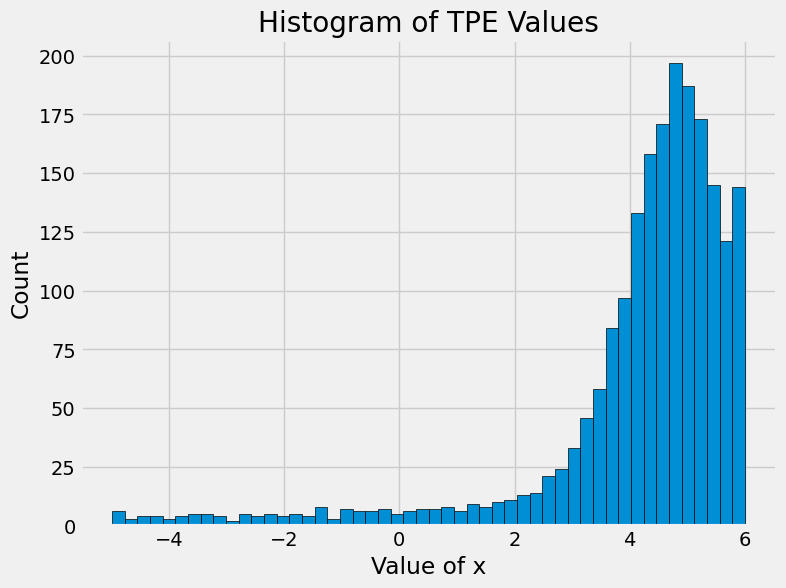

In [18]:
plt.figure(figsize = (8, 6))
plt.hist(tpe_results['x'], bins = 50, edgecolor = 'k');
plt.title('Histogram of TPE Values'); plt.xlabel('Value of x'); plt.ylabel('Count');

Sure enough, the algorithm tried many values closer to 4.9 that anywhere else! This clearly shows the benefits of choosing the next values based on the past values: more evaluations of promising values.

Best Loss of -219.8012 occured at iteration 1154


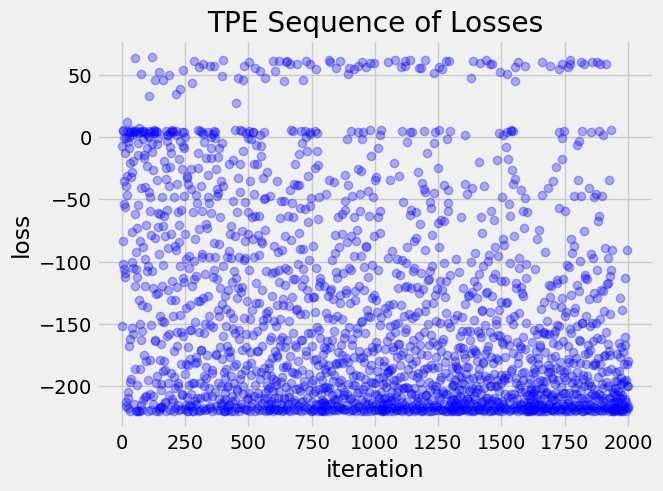

In [19]:
# Sort with best loss first
tpe_results = tpe_results.sort_values('loss', ascending = True).reset_index()

plt.plot(tpe_results['iteration'], tpe_results['loss'], 'bo', alpha = 0.3);
plt.xlabel('iteration'); plt.ylabel('loss'); plt.title('TPE Sequence of Losses');

print('Best Loss of {:.4f} occured at iteration {}'.format(tpe_results['loss'][0], tpe_results['iteration'][0]))

### Random Results

We should contrast the TPE results with those from random search. Here we do not expect to see any trend in values evaluated over time because the values are selected randomly. 

In [20]:
rand_results = pd.DataFrame({'loss': [x['loss'] for x in rand_trials.results], 'iteration': rand_trials.idxs_vals[0]['x'],
                            'x': rand_trials.idxs_vals[1]['x']})
                            
rand_results.head()

,loss,iteration,x
0,-151.573739,0,3.950209
1,-6.871627,1,-1.695365
2,-102.075271,2,-3.383409
3,5.540063,3,-0.558446
4,4.573759,4,0.531941


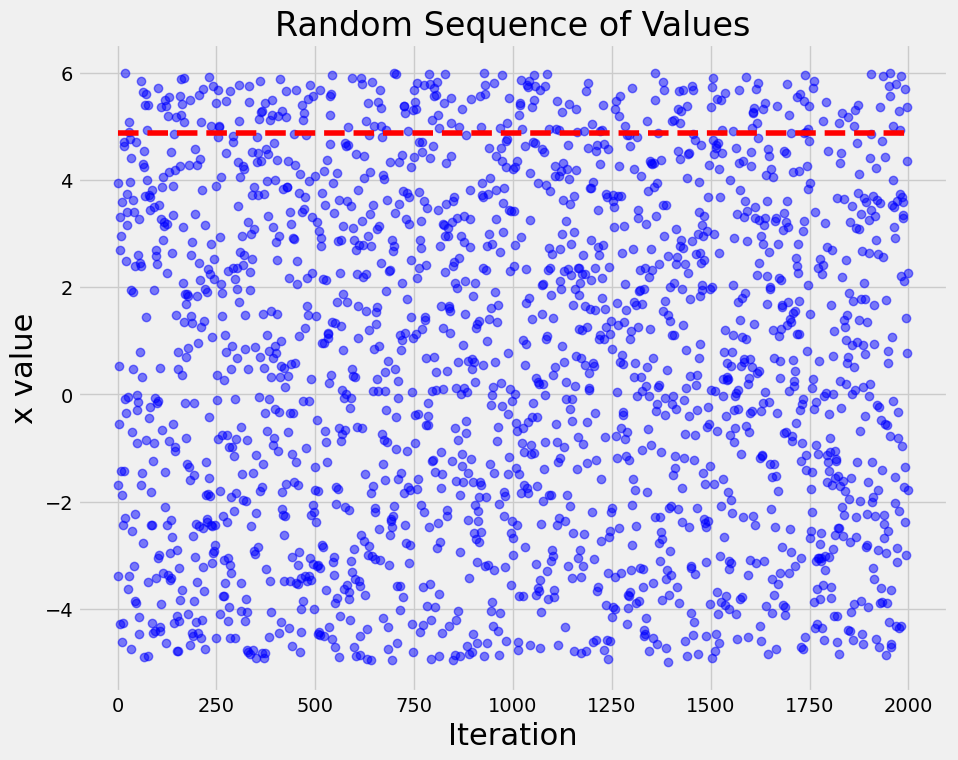

In [21]:
plt.figure(figsize = (10, 8))
plt.plot(rand_results['iteration'], rand_results['x'],  'bo', alpha = 0.5);
plt.xlabel('Iteration', size = 22); plt.ylabel('x value', size = 22); plt.title('Random Sequence of Values', size = 24);
plt.hlines(minx, 0, 2000, linestyles = '--', colors = 'r');

Clearly, the random algorithm is just "randomly" choosing the next set of values to try! There is no logical order here.

Best Loss of -219.7984 occured at iteration 1735


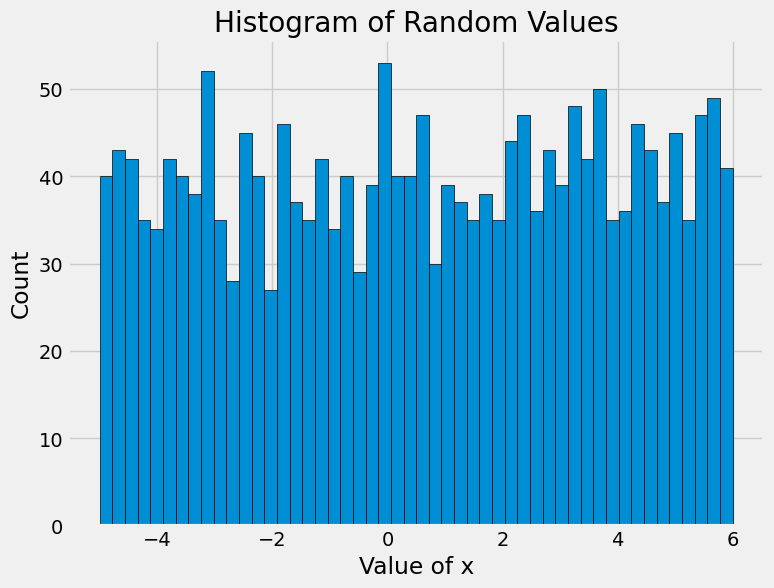

In [22]:
# Sort with best loss first
rand_results = rand_results.sort_values('loss', ascending = True).reset_index()

plt.figure(figsize = (8, 6))
plt.hist(rand_results['x'], bins = 50, edgecolor = 'k');
plt.title('Histogram of Random Values'); plt.xlabel('Value of x'); plt.ylabel('Count');

# Print information
print('Best Loss of {:.4f} occured at iteration {}'.format(rand_results['loss'][0], rand_results['iteration'][0]))

Again, there is no discernable clustering because this method is choosing the next values randomly. In this case, it happended across the minimum of the function because it was a relatively simple problem and we used many iterations. This would not likely be the case when we are optimizing more complex functions.

# Slightly Advanced Concepts

These probably should not be called advanced but smarter concepts because they will make our jobs easier. We will cover two upgrades we can make:

* Smarter domain space over which to search
* Return more useful information from the objective function

These will be helpful when it comes time for hyperparameter optimization. Master the details on the easy problems so you can use the tools more effectively on the difficult problems.

### Better Domain Space

In this problem, we can cheat because we know where the minimum is and therefore can define a region of higher probability around this value of x. In more complicated problems, we don't have a graph to show us the minimum, but we can still use experience and knowledge to inform our choice of a domain space. 

Here we will make a normally distributed domain space around the value where the minimum of the objective function occurs, around 4.9. This is simple to do in Hyperopt.

In [23]:
# Normally distributed space
space = hp.normal('x', 4.9, 0.5)

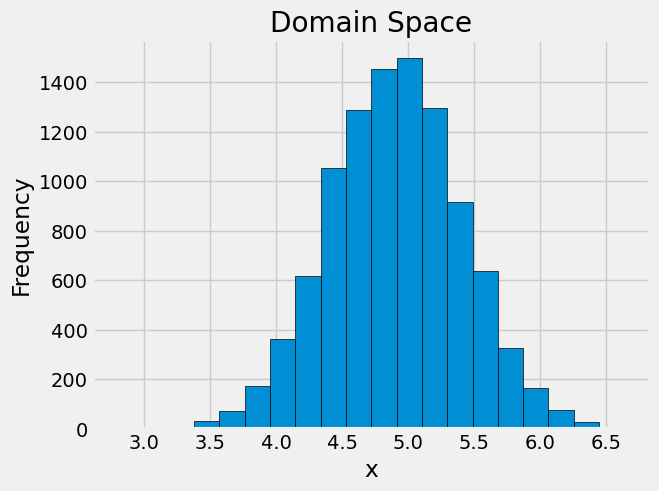

In [24]:
samples = []

# Sample 10000 values from the range
for _ in range(10000):
    samples.append(sample(space))
    

# Histogram of the values
plt.hist(samples, bins = 20, edgecolor = 'black'); 
plt.xlabel('x'); plt.ylabel('Frequency'); plt.title('Domain Space');

Much closer to the true value! This would help both the random search and the TPE find the minimum quicker (for random search it would help because we are concentrating the possible values around the optimum).

## More Useful Trials Object

Another modification to make is to return more useful information from the objective function. We do this using a dictionary with any information we want included. The only requirements are that the dictionary must contain a single real-valued metric to minimize stored under a `"loss"` key and whether the function sucessfully ran, stored under a `"status"` key. Here we make the modifications to the objective to store the value of x as well as the time to evaluate.

In [25]:
from hyperopt import STATUS_OK
from timeit import default_timer as timer

In [26]:
def objective(x):
    """Objective function to minimize with smarter return values"""
    
    # Create the polynomial object
    f = np.poly1d([1, -2, -28, 28, 12, -26, 100])

    # Evaluate the function
    start = timer()
    loss = f(x) * 0.05
    end = timer()
    
    # Calculate time to evaluate
    time_elapsed = end - start
    
    results = {'loss': loss, 'status': STATUS_OK, 'x': x, 'time': time_elapsed}
    
    # Return dictionary
    return results

We run the algorithm the same as before. We'll create a new `Trials` object to save new results.

In [28]:
# New trials object
trials = Trials()

# Run 2000 evals with the tpe algorithm
best = fmin(fn=objective, space=space, algo=tpe_algo, trials=trials, 
                max_evals=2000, rstate= np.random.default_rng(50))

100%|███| 2000/2000 [00:07<00:00, 256.43trial/s, best loss: -219.80120392348482]


This time our trials object will have all of our information in the `results` attribute. 

In [29]:
results = trials.results
results[:2]

[{'loss': -218.89783504596167,
  'status': 'ok',
  'x': 4.792866002220728,
  'time': 2.816300002450589e-05},
 {'loss': -141.0265342810952,
  'status': 'ok',
  'x': 5.539274037790242,
  'time': 1.577200009705848e-05}]

This time we have more information from the results. We can extract the results into a dataframe for inspect and plotting if we like. 

In [30]:
# Results into a dataframe
results_df = pd.DataFrame({'time': [x['time'] for x in results], 
                           'loss': [x['loss'] for x in results],
                           'x': [x['x'] for x in results],
                            'iteration': list(range(len(results)))})

# Sort with lowest loss on top
results_df = results_df.sort_values('loss', ascending = True)
results_df.head()

,time,loss,x,iteration
1211,0.000017,-219.801204,4.878157,1211
667,0.000024,-219.801204,4.878093,667
1137,0.000018,-219.801203,4.878059,1137
1446,0.000019,-219.801201,4.877990,1446
838,0.000021,-219.801201,4.877970,838


This was a simple optimization problem, so the lowest score obtained does not really differ from that with the uniform distribution. It took around the same number of iterations to converge. We can compare the distribution though to see if better values were tried.

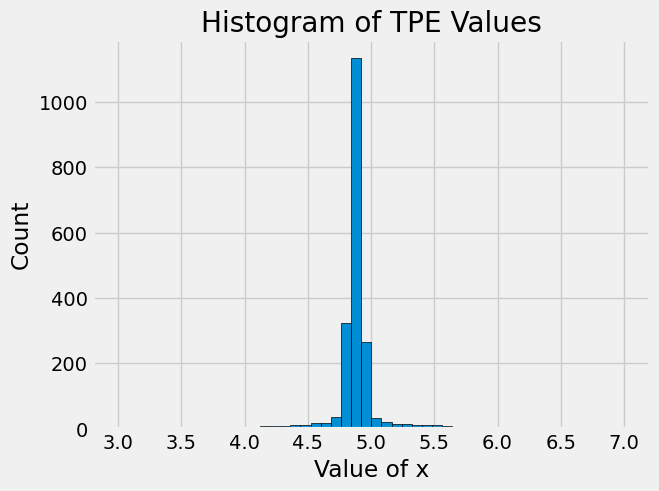

In [31]:
plt.hist(results_df['x'], bins = 50, edgecolor = 'k');
plt.title('Histogram of TPE Values'); plt.xlabel('Value of x'); plt.ylabel('Count');

Indeed the values of x evaluated cluster much closer to the optimum! The algorithm spend much more time around the best value than searching the domain space. We can compare this distribution to that attained with the TPE algorithm on the uniform domain using a Kernel Density Estimate Plot.

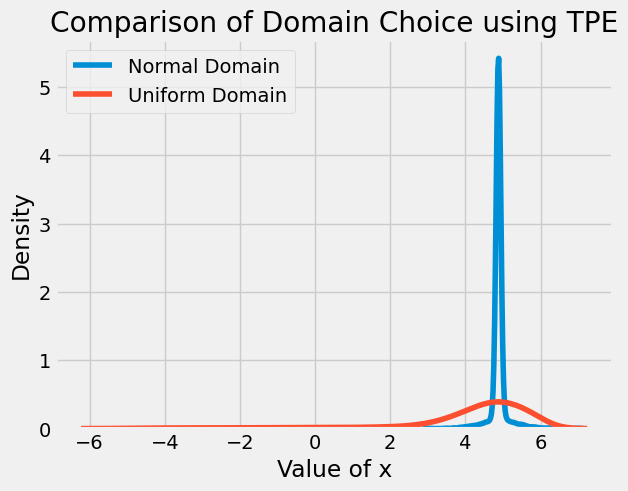

In [32]:
sns.kdeplot(results_df['x'], label = 'Normal Domain')
sns.kdeplot(tpe_results['x'], label = 'Uniform Domain')
plt.legend(); plt.xlabel('Value of x'); plt.ylabel('Density'); plt.title('Comparison of Domain Choice using TPE');

In [33]:
print('Lowest Value of the Objective Function = {:.4f} at x = {:.4f} found in {:.0f} iterations.'.format(results_df['loss'].min(),
                                                                             results_df.loc[results_df['loss'].idxmin()]['x'],
                                                                             results_df.loc[results_df['loss'].idxmin()]['iteration']))

Lowest Value of the Objective Function = -219.8012 at x = 4.8782 found in 1211 iterations.


Well that definitely shows the value of choosing a good prior! When it comes to hyperparameter tuning, we often do not know ahead of time what values to concentrate around but we can try to use past experience or the work of others to inform our search spaces. 

#### One-Line Optimization

In [34]:
# Just because you can do it in one line doesn't mean you should! 
best = fmin(fn = lambda x: np.poly1d([1, -2, -28, 28, 12, -26, 100])(x) * 0.05,
            space = hp.normal('x', 4.9, 0.5), algo=tpe.suggest, 
            max_evals = 2000)

best

100%|███| 2000/2000 [00:08<00:00, 234.51trial/s, best loss: -219.80120386528262]


{'x': 4.878099119863228}

# Conclusions

In this notebook, we saw a basic implementation of Bayesian Model-Based optimization using Hyperopt. This requires four parts:

1. Objective: what we want to minimize
2. Domain: values of the parameters over which to minimize the objective
3. Hyperparameter optimization function: how the surrogate function is built and the next values are proposed
4. Trials consisting of score, parameters pairs

The differences between random search and and Sequential Model-Based Optimization is clear: random search is _uninformed_ and therefore requires more trials to minimize the objective function. The Tree Parzen Estimator, an algorithm used for SMBO, spends more time choosing the next values, but overall requires fewer evaluations of the objective function because it is able to _reason_ about the next values to evaluate. Over many iterations, SMBO algorithms concentrate the search around the most promising values, yielding:

* Lower scores on the objective function
* Faster optimization

Bayesian model-based optimiziation means construction a probability model $p(y | x)$ of the objective function and updating this model as more information is collected. As the number of evaluations increases, the model (also called a surrogate function) becomes a more accurate respresentation of the objective function and the algorithm spends more time evaluating promising values.


This notebook showed a the basic implementation of Bayesian Model-Based optimization using Hyperopt, but already we can see how it has significant advantages over random or grid search based methods. In future notebooks we will explore using Bayesian model-based optimization on more complex problems, namely hyperparameter optimization of machine learning models. 